In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-ab-testing/marketing_AB.csv


# Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
print(df.head())

   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  


In [4]:
df.duplicated(subset='user id').sum()

0

In [5]:
df.drop(['Unnamed: 0', 'user id'], axis=1, inplace=True)
print(df.columns)

Index(['test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')


# EDA

In [6]:
df.head(5)

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


In [7]:
df.dtypes

test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   test group     588101 non-null  object
 1   converted      588101 non-null  bool  
 2   total ads      588101 non-null  int64 
 3   most ads day   588101 non-null  object
 4   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 18.5+ MB


In [9]:
df.shape

(588101, 5)

In [10]:
print(df['test group'].unique())
print(df['converted'].unique())
print(df['most ads day'].unique())
print(df['most ads hour'].unique())

['ad' 'psa']
[False  True]
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
[20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


In [11]:
df.isna().sum()

test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

# Data Preprosssing

In [12]:
df['converted'] = df['converted'].astype(int)
df.dtypes

test group       object
converted         int64
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

# Data Visualization

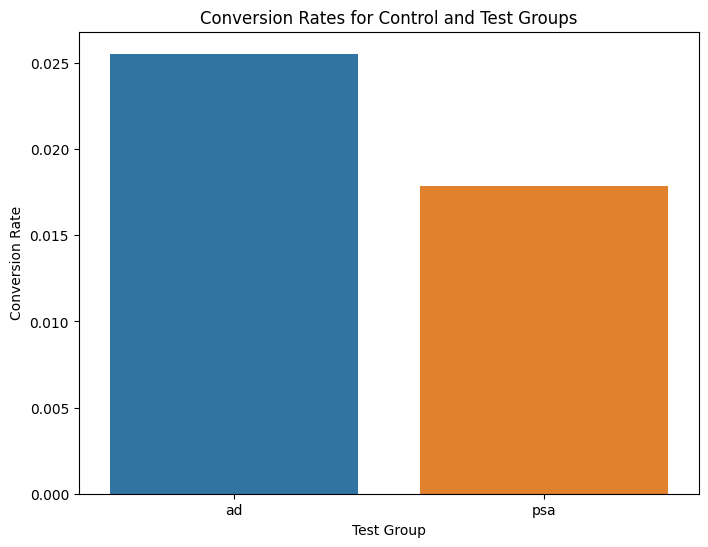

In [13]:
conversion_rates = df.groupby('test group')['converted'].mean().reset_index()
conversion_rates.columns = ['Test Group', 'Conversion Rate']
plt.figure(figsize = (8,6))
sns.barplot(data=conversion_rates, x='Test Group', y='Conversion Rate')
plt.title('Conversion Rates for Control and Test Groups')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()

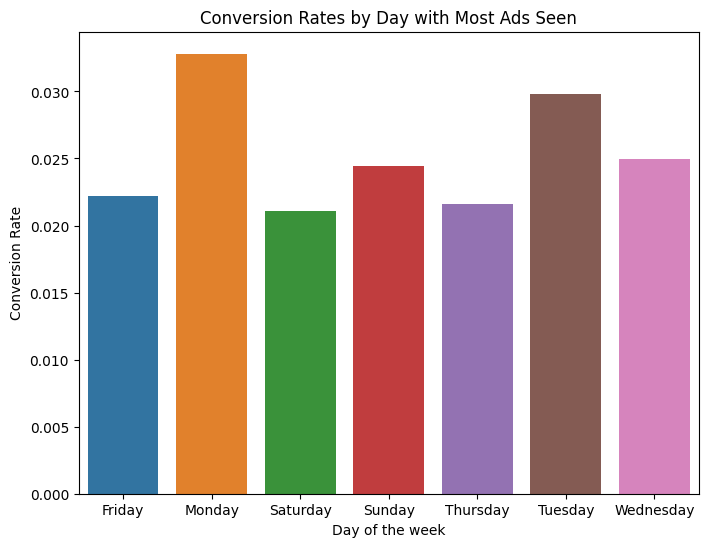

In [14]:
conversion_rates = df.groupby('most ads day')['converted'].mean().reset_index()
conversion_rates.columns = ['most ads day', 'Conversion Rate']
plt.figure(figsize = (8,6))
sns.barplot(data=conversion_rates, x='most ads day', y='Conversion Rate')
plt.title('Conversion Rates by Day with Most Ads Seen')
plt.xlabel('Day of the week')
plt.ylabel('Conversion Rate')
plt.show()

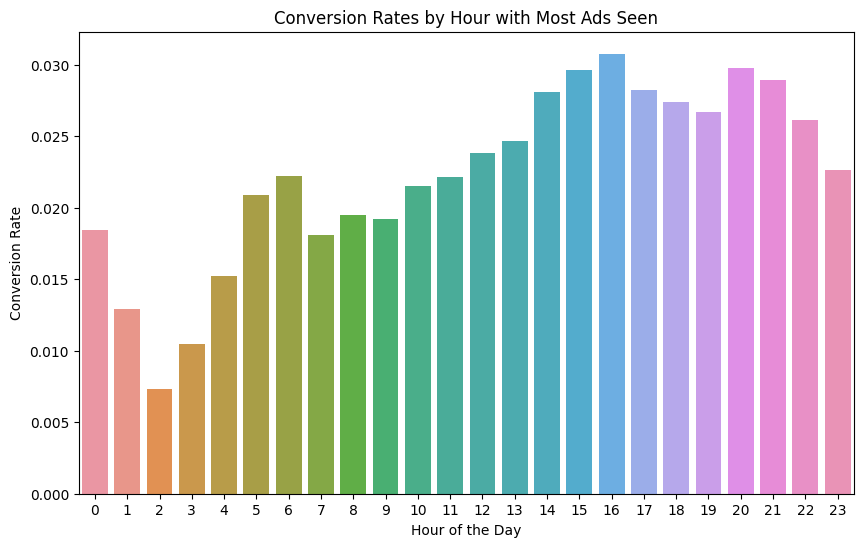

In [15]:
conversion_rates = df.groupby('most ads hour')['converted'].mean().reset_index()
conversion_rates.columns = ['most ads hour', 'Conversion Rate']
plt.figure(figsize = (10,6))
sns.barplot(data=conversion_rates, x='most ads hour', y='Conversion Rate')
plt.title('Conversion Rates by Hour with Most Ads Seen')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate')
plt.show()

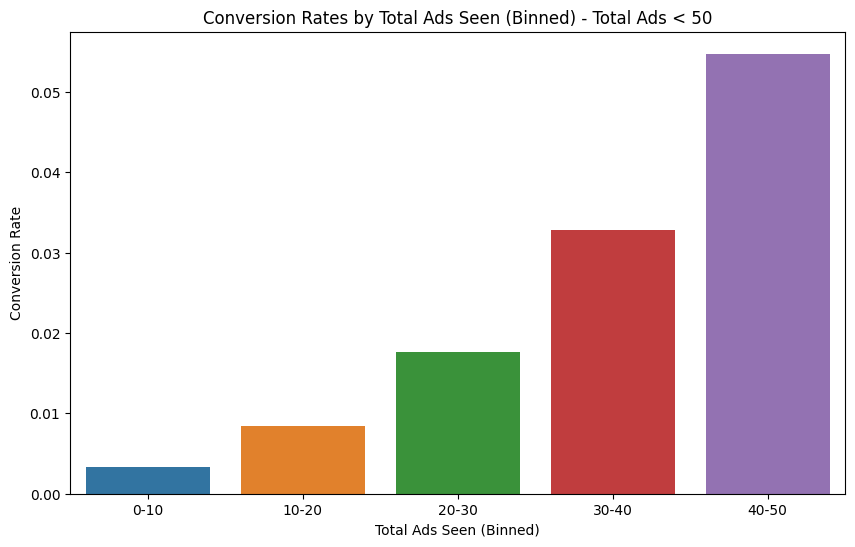

In [16]:
df_subset = df[df['total ads'] < 50].copy()
df_subset.loc[:, 'total_ads_bin'] = pd.cut(df_subset['total ads'], bins=[-1,10, 20, 30, 40, 50], 
                                           labels=['0-10', '10-20', '20-30', '30-40', '40-50'])

ads_conversion_rate_bin = df_subset.groupby('total_ads_bin')['converted'].mean().reset_index()
plt.figure(figsize = (10,6))
sns.barplot(data=ads_conversion_rate_bin, x='total_ads_bin', y='converted')
plt.title('Conversion Rates by Total Ads Seen (Binned) - Total Ads < 50')
plt.xlabel('Total Ads Seen (Binned)')
plt.ylabel('Conversion Rate')
plt.show()

# **Statistical Testing**

In [17]:
#1 t-test

from scipy import stats

control_group = df[df['test group'] == 'psa']
test_group = df[df['test group'] == 'ad']

t_stat, p_val = stats.ttest_ind(test_group['converted'], control_group['converted'])
print(f"t-Test Result: t-statistic={t_stat}, P-value={p_val}")

t-Test Result: t-statistic=7.37040597428566, P-value=1.7033052627831264e-13


In [18]:
alpha = 0.05
if p_val<alpha:
    print("Reject the null hypothesis: the 'ad' group is better.")
else:
    print("Fail to reject the null hypothesis: there is not evidence show the 'ad' group is better than 'psa' group.")

Reject the null hypothesis: the 'ad' group is better.


In [19]:
#2 chi^2 test
from scipy.stats import chi2_contingency

for column in df.columns:
    if column not in ['test group', 'converted']:
        contingency_table = pd.crosstab(df[column], df['converted'])
        
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        
        print(f"\nChi-squared test for {column} vs. converted: ")
        print(f"Chi-squared value: {chi2}")
        print(f"p-value: {p_value}")
        
        if p_value<alpha:
            print(f"The difference in conversion rate across {column} is statistically significant")
        else:
            print(f"There is no significant difference in conversion rate across {column}")
            


Chi-squared test for total ads vs. converted: 
Chi-squared value: 48001.99019466958
p-value: 0.0
The difference in conversion rate across total ads is statistically significant

Chi-squared test for most ads day vs. converted: 
Chi-squared value: 410.0478857936585
p-value: 1.932184379244731e-85
The difference in conversion rate across most ads day is statistically significant

Chi-squared test for most ads hour vs. converted: 
Chi-squared value: 430.76869230822086
p-value: 8.027629823696771e-77
The difference in conversion rate across most ads hour is statistically significant


In [20]:
#3 ANOVA test

anova_result = stats.f_oneway(
    df_subset[df_subset['total_ads_bin'] == '0-10']['converted'],
    df_subset[df_subset['total_ads_bin'] == '10-20']['converted'],
    df_subset[df_subset['total_ads_bin'] == '20-30']['converted'],
    df_subset[df_subset['total_ads_bin'] == '30-40']['converted'],
    df_subset[df_subset['total_ads_bin'] == '40-50']['converted']
)

print(f"Total Ads (Binned) Analysis - F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")

if anova_result.pvalue<alpha:
    print(f"The difference in conversion rate across total ads is statistically significant")
else:
    print(f"There is no significant difference in conversion rate across total ads")

Total Ads (Binned) Analysis - F-statistic: 1858.7880783289397, P-value: 0.0
The difference in conversion rate across total ads is statistically significant
